# FINAL PROJECT 3 - EXPLORATORY ANALYSIS

Here, we will explore the relationships between weather conditions and elevator callbacks.
We have two sources of data:
1. 3 years of elevator maintenance records from a major US city.
2. Daily weather records from the same city.

#### Maintenance Data
Our maintenance data consists of 3 years worth of elevator maintenance records for a major US city. The data has been heavily processed from its original form - The features we have extracted are as follows:
1. USID (a unique identifier) of each unit in town.
2. Reported date of every maintenance visit 
3. Date of last visit to the unit in question beore the reported date
4. Reason for last visit (callback, preventative maintenance, repair, service inspection)
5. Unit Description (what kind of unit - i.e. Traction, hydraulic, geared, gearless, etc.)

#### Weather Data
This data was sourced from www.wunderground.com. The data includes daily records of maximum, minimum, and mean values for the following features:
1. Temperature
2. Humidity
3. Dew point
4. Air pressure

Additionally, the weather data includes records of daily precipitation (measured in inches).

#### Pre-processing
The data was pre-processed using a number of tables created in PostgreSQL and a handful of cleanup scripts written in Python 2.7.

The maintenance data and the weather data were manipulated in such a way that each row contains the five variables mentioned in the Maintenance Data section, in addition to the maximum, minimum, and mean values of each weather variable spanning the days in between maintenance visits. The exception here is precipitation, which was instead aggregated to the total precipitation between the previous visit and the current visit.


#### Daily Aggregated Data
In addition to the above, another dataframe was created showing the sum of the callbacks on a daily basis for the entire 3-year span. This data was paired with a 30-day lagged version of the weather data. This particular configuration may be useful for forecasting the "lump sum" of calbacks over time.

#### Analysis:
Our goal for this notebook is to look at relationships between the callback volume and the weather conditions of the city in question. Following our analysis, an attempt will be made to construct a predictive model which will forecast when there will be an increase in the total callback volume.

Note that the final data format was saved in Pandas' binary "pickle" format to reduce loading times within this notebook. To maintain compatibility with different programming environtments, a CSV file of the final format will be included in the final project folder. Also included is the final Python cleanup script used to combine the different tables generated by PostgreSQL.

In [1]:
#import packages
import numpy as np
import pandas as pd

In [2]:
#import dataset 1
df = pd.read_pickle('pickles/notebook_ready_pickle')
df.head()

,usid,reported,maxTemp,meanTemp,minTemp,maxHum,meanHum,minHum,maxPres,meanPres,...,pm,rpr,si,cblast,pmlast,rprlast,silast,daysSince,wkdRpt,wkdLv
1,US10000,2013-09-16,95.0,68.615385,48.0,100.0,62.615385,10.0,30.34,30.040000,...,1,0,0,0.0,1.0,0.0,0.0,13.0,0,1.0
2,US10000,2013-12-11,81.0,42.697674,-13.0,100.0,54.883721,7.0,30.77,30.020233,...,1,0,0,0.0,1.0,0.0,0.0,86.0,2,0.0
3,US10000,2014-01-06,65.0,32.423077,-4.0,100.0,51.961538,10.0,30.60,30.103077,...,1,0,0,0.0,1.0,0.0,0.0,26.0,0,2.0
4,US10000,2014-01-31,62.0,32.960000,1.0,100.0,49.960000,2.0,30.67,30.054000,...,1,0,0,0.0,1.0,0.0,0.0,25.0,4,0.0
5,US10000,2014-03-05,65.0,30.090909,-17.0,100.0,60.000000,6.0,30.65,29.979697,...,1,0,0,0.0,1.0,0.0,0.0,33.0,2,4.0


### Description of column variables:
##### Dataset 1

In [3]:
df.columns

Index([u'usid', u'reported', u'maxTemp', u'meanTemp', u'minTemp', u'maxHum',
       u'meanHum', u'minHum', u'maxPres', u'meanPres', u'minPres', u'maxDew',
       u'meanDew', u'minDew', u'totalprecip', u'GEARED_MR', u'GLS_MR',
       u'GLS_MRL', u'HOLELESS_HYDRO', u'HOLE_HYDRO', u'HYDRO_MRL', u'OTHER',
       u'ROPED_HYDRO', u'TEL_HYDRO', u'TRAD_HYDRO', u'TWINPOST_HYDRO',
       u'lastVisit', u'cb', u'pm', u'rpr', u'si', u'cblast', u'pmlast',
       u'rprlast', u'silast', u'daysSince', u'wkdRpt', u'wkdLv'],
      dtype='object')

The text shown refers to the variables extracted from our datasets.
Below is a description of each variable. Starting from the beginning:

1. usid - (string) Unique identifier given to each elevator in America. 
2. reported - (datetime) Date on which a maintenance visit was called in
3. maxTemp - (float) The maximum temperature over the days ranging from the lastVisit date and the reported date
4. meanTemp  - (float) The mean temperature over the days ranging from the lastVisit date and the reported date
5. minTemp - (float) the minimum temperature over the days ranging from the lastVisit date and the reported date
6. maxHum - (float) the maximum humidity over the days ranging from the lastVisit date and the reported date
7. minHum - (float) the minimum humidity over the days ranging from the lastVisit date and the reported date
8. maxPres - (float) the maximum pressure... ' '
9. meanPres - (float) the mean pressure... ' '
10. minPres - (float) the minimum pressure... ' '
11. maxDew - (float) the maximum dew point ... ' '
12. meanDew - (float) the mean dew point .... ' '
13. minDew - (float) the minimum dew point ... ' '
14. totalprecip - (float) the total precipitation over the days ranging from the lastVisit date and the reported date
15. GEARED_MR - (binary) This unit is a geared elevator with a machine room
16. GLS_MR - (binary) This unit is a gearless elevator without a machine room
17. HOLELESS_HYDRO - (binary) this unit is a holeless hydraulic elevator
18. HOLE_HYDRO - (binary) this unit is a holed hydraulic elevator
19. HYDRO_MRL - (binary) this unit is a machine-room-less hydraulic elevator
20. OTHER - (binary) this unit is none of the above types. Includes escalators, homelifts, and dumbwaiters
21. ROPED_HYDRO - (binary) this unit is a roped hydraulic elevator.
22. TEL_HYDRO - (binary) this unit is a hydraulic elevator with a telescopic jack
23. TRAD_HYDRO - (binary) this unit is a traditional hydraulic elevator
24. TWINPOST_HYDRO - (binary) this unit is a twinpost hydrauli elevator
25. lastVisit - (datetime) date of the last maintenance visit before the reported date
26. cb - (binary) the maintenance call on the reported date was a callback
27. pm - (binary) the maintenance call on the reported date was a preventative maintenance call
28. rpr - (binary) the maintenance call on the reported date was a repair call.
29. si - (binary) the maintenance call on the reported date was a safety inspection call
30. cblast - (binary) the maintenance call on the lastVisit date was a callback
31. pmlast - (binary) the maintenance call on the lastVisit date was a preventative maintenance call
32. rprlast - (binary) the maintenance call on the lastVisit date was a repair call
33. silast - (binary) the maintenance call on the lastVisit date was a safety inspection call
34. daysSince - (integer) number of days elapsed between lastVisit and reported
35. wkdRpt - (integer) weekday of the reported date (0 - 6, where Monday is 0 and Sunday is 6)
36. wkdLv - (integer) weekday of the lastVisit date (0 - 6, where Monday is 0 and Sunday is 6)

#### Daily Totals Dataset
Here we read in the daily totals data mentioned before.
The daily callback totals are designated as cb, the weekday designated as wkd, and the weather variables (meanTemp, meanPres, meanDew) are the average daily weather values from one month prior to the reported date. 

Note: The reported date is not shown, rather, the index is used to show how many days have passed since 7-01-2013.

In [4]:
#import daily totals dataset
dfDaily = pd.read_pickle('pickles/dff_pickle')
dfDaily = dfDaily.astype(float)
dfDaily.head()

,meanTemp,meanPres,meanDew,meanHum,wkd,cb
0,75.0,30.11,47.0,46.0,2.0,43.0
1,76.0,29.96,47.0,49.0,3.0,36.0
2,75.0,29.92,45.0,41.0,4.0,35.0
3,74.0,30.07,52.0,57.0,5.0,3.0
4,74.0,30.03,49.0,51.0,6.0,18.0


## Analysis

#### Part 1 - Unit Types

First off, let's have a look at the callback frequencies of each unit type. This alone would be good information to know.

We will generate two plots - one plot showing the percentage makeup of our callbacks, and another showing the percentage makeup of all maintenance calls by unit type

In [5]:
unitTypeList = df.columns[16:26].tolist() + ['cb']

#create data frame for callbacks by unit type
dfUnitTypes = df[unitTypeList]
dfUnitTypes = dfUnitTypes[dfUnitTypes.cb==1]
SeriesUnitTypes = dfUnitTypes.sum()
SeriesUnitTypes = SeriesUnitTypes/SeriesUnitTypes.sum() #turn into a percentage for relative frequencies

#create dataframe for unit type relative to entire dataset
numUnitTypes = df[unitTypeList].sum()
numUnitTypes = numUnitTypes/numUnitTypes.sum()


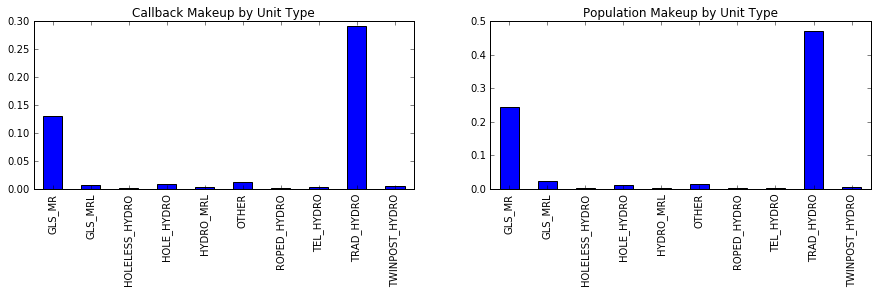

In [6]:
#create plots
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
SeriesUnitTypes.drop('cb').plot.bar(ax=ax)
numUnitTypes.drop('cb').plot.bar(ax=ax2)
ax.set_title('Callback Makeup by Unit Type')
ax2.set_title('Population Makeup by Unit Type')

As shown above, it is apparent that the majority of our callback tickets come from gearless machine room and traditional hydraulic elevators. However, this may be due in part to the fact that these two categories make up the majority of our population. Let's have another look at the population makeup by counting the number of each INDIVIDUAL unit type.

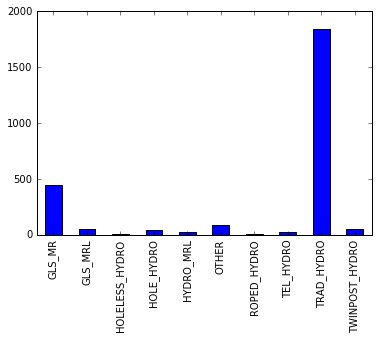

In [7]:
l2 = ['usid'] + unitTypeList
unq = df[l2].drop('cb',axis=1).copy()
unq.drop_duplicates().drop('usid',axis=1).sum().plot.bar()

The plot above verifies our previous hunch. This city seems to have a very large percentage of hydraulic elevators.

Let's compare the average time between visits for all unit types. This may factor into it as well.

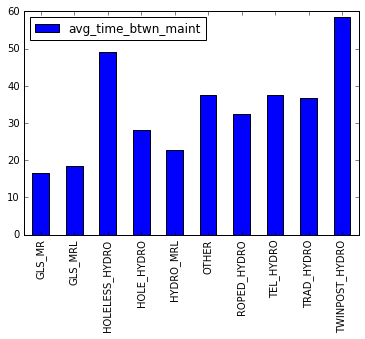

In [8]:
dfTimeBetween = pd.DataFrame(index = unitTypeList[:-1],columns=['avg_time_btwn_maint'])
for col in unitTypeList[:-1]:
    dfTimeBetween.ix[col] = df[df[col]==1].daysSince.mean()

dfTimeBetween.plot.bar()

Interestingly enough, the average time between maintenance calls seems to be highest on the hydraulic systems as well, while the traction (GLS_MR, GLS_MRL) systems tend to have the most frequent maintenance visits. 

There could be a connection between the low cost of the hydraulic units and the spending habits of the customers who buy them.

Next, let's have a look at the weather patterns between callbacks.

#### Part 2 - Weather Conditions
Next, let's look at total callback volume from our daily aggregates, and see if there is any correlation between the callback volume and the weather.

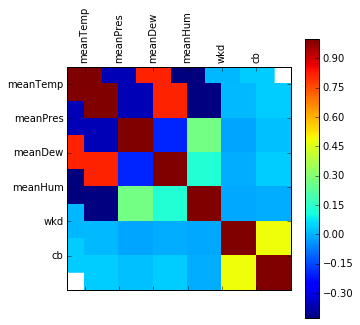

In [9]:
#run script containing various helper functions... easier than importing and having to restart the kernel...
%run CallbackHelpers.py

plot_corr(dfDaily.astype(float),size=5)

The figure above is a correlation plot, showing the how correlated each variable is with the next.
Disappointingly, we do not see very much correlation between callbacks and the weather. However, because this is a fixed-lag, it could be that the weather parameters on the day 30 days before our callbacks are not representative of any factors which could cause a callback.

Though interestingly enough, we do see a reasonable correlation between callback volume and day of the week.

Now let's have a look at the weather patterns between maintenance visits on days where we have callbacks.

For a quick glance, we will group our incidents by those which are callbacks and those which are not callbacks and look at the difference between average weather conditions since the last time someone was on the jobsite. This may give an indication as to whether the weather conditions are correlated to callback issues.

For this part, we will add new features in addition to the ones we have: For each weather condition with a max/min quantity, we will add a peak to peak feature. Peak to peak is defined as the difference between the maximum and the minimum over a certain time period. This will hopefully capture any rapid or volatile weather changes over a short time period.

In [10]:
df['p2pTemp'] = df.maxTemp - df.minTemp
df['p2pHum'] = df.maxHum - df.minHum
df['p2pPres'] = df.maxPres - df.minPres
df['p2pDew'] = df.maxDew - df.minDew

weatherCols = df.columns[2:15].tolist() + ['daysSince','p2pTemp','p2pHum','p2pPres','p2pDew']
dfBtwnCB = df[weatherCols][df.cb==1]
dfBtwn = df[weatherCols][df.cb==0]


dfBtwnCB.median()/dfBtwn.median()
dfBtwnCB.head()

,maxTemp,meanTemp,minTemp,maxHum,meanHum,minHum,maxPres,meanPres,minPres,maxDew,meanDew,minDew,totalprecip,daysSince,p2pTemp,p2pHum,p2pPres,p2pDew
38,96.0,69.275862,43.0,93.0,45.275862,7.0,30.34,29.872069,29.47,60.0,40.034483,14.0,0.4010,29.0,53.0,86.0,0.87,46.0
39,93.0,71.833333,54.0,97.0,53.083333,12.0,30.42,30.046250,29.76,62.0,49.875000,30.0,3.8903,24.0,39.0,85.0,0.66,32.0
41,81.0,45.808511,-9.0,100.0,52.893617,9.0,30.77,30.060426,29.33,50.0,25.638298,-11.0,1.1506,47.0,90.0,91.0,1.44,61.0
42,69.0,32.557692,-13.0,100.0,57.769231,7.0,30.92,30.092885,29.35,36.0,16.346154,-16.0,0.6812,52.0,82.0,93.0,1.57,52.0
43,61.0,36.000000,18.0,100.0,59.375000,12.0,30.44,30.173750,29.82,33.0,18.500000,-3.0,0.0004,8.0,43.0,88.0,0.62,36.0


Looking at the median values above, it seems like the peak to peak variables are the most different between callbacks and non-callbacks. Minimum humidity seems to be significantly different as well. We can test the validity of this observation by performing a t-test.

In [11]:
from scipy.stats import ttest_ind

t_test= ttest_ind((dfBtwnCB),(dfBtwn),equal_var=False)

pv = t_test.pvalue

for n, m in enumerate(dfBtwnCB.columns):
    print m, pv[n]

maxTemp 2.09470377524e-48
meanTemp 2.74339399537e-15
minTemp 5.17603031031e-154
maxHum 8.33028901516e-218
meanHum 0.359526592072
minHum 1.62851249681e-203
maxPres 5.33432786289e-249
meanPres 0.633888428558
minPres 0.0
maxDew 1.7033739915e-20
meanDew 8.93608867124e-19
minDew 5.74161476814e-198
totalprecip 1.18992314325e-102
daysSince 4.06814812606e-138
p2pTemp 0.0
p2pHum 0.0
p2pPres 0.0
p2pDew 0.0


The values shown above represent probabilities that the averages between each group are significantly different.

We see here a lot of very low p-values, which indicates that there very well may be some statistical significance of the difference between the callback group and the non-callback group. In fact, the only variables which failed the t-test was the mean air pressure (meanPres) and the mean humidity (meanHum).

That being said, we should be careful. Averages can have a tendency to mislead us. We will keep this in mind as we move forward.

#### Part 3 - Time and Seasonality
Here, we'll investigate the effect of time and seasonality on our callback volume.
We'll begin by looking at how the daily aggregates change throughout the work week

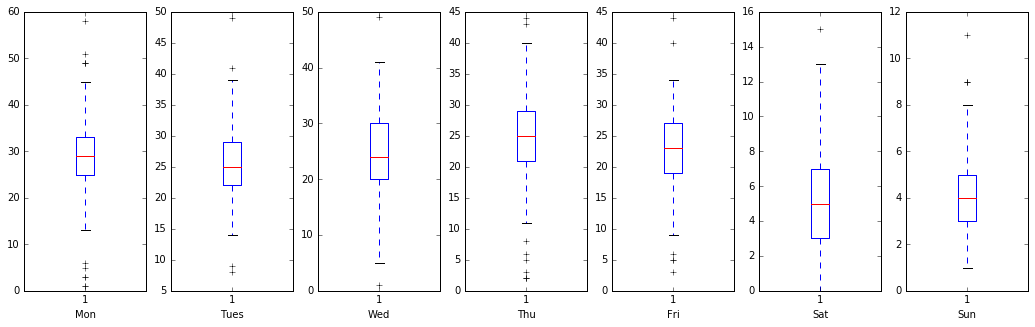

In [12]:
%run CallbackHelpers.py
# load pickle of dfDaily with datetime index
dfInCt = pd.read_pickle('pickles/dff2_datetime')
#helper function which creates box plots
box_dow(dfInCt)

Looking at the boxplots, we can see that there is some weekly fluctuation depending on the day, though the weekdays are fairly volatile. Let's have a look at the autocorrelation plot for callbacks to see how periodic the callback volume is.

(0, 365)

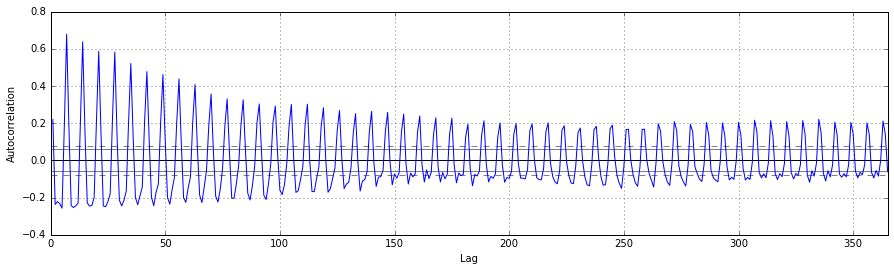

In [13]:
from pandas.tools.plotting import autocorrelation_plot
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)
autocorrelation_plot(dfInCt.cb,ax=ax)
ax.set_xlim(0,365)

The above plot is the autocorrelation of the daily callback volume. Only the first year is shown for visibility.
Looking at the plot above, we see that the peaks are fairly consistent. This confirms the periodicity of the callback volume.

## Next Steps:

After exploring the data, it looks like there are several models to evaluate. 

**Treat this as a regression problem**

Predict the number of callbacks on a particular day given the day of the week and the weather conditions between visits.

**Use Time-series modeling**

Predict the number of callbacks by creating an autoregressive model, looking only at the callback volume of previous days
